In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import datetime
import os
import sys

In [2]:
from discopro.grammar import tensor
from discopro.anaphora import connect_anaphora_on_top
from lambeq import BobcatParser, NumpyModel, AtomicType, Rewriter, Dataset, QuantumTrainer, SPSAOptimizer , AtomicType, IQPAnsatz, RemoveCupsRewriter, UnifyCodomainRewriter, BinaryCrossEntropyLoss
from lambeq.backend.grammar import Spider, Ty
from lambeq.backend.quantum import Box, qubit, SelfConjugate, Ry, Diagram
from contextuality.model import Model, Scenario, CyclicScenario

In [3]:
remove_cups = RemoveCupsRewriter()

parser = BobcatParser()
rewriter = Rewriter(['auxiliary',
                     'connector',
                     'coordination',
                     'determiner',
                     'object_rel_pronoun',
                     'subject_rel_pronoun',
                     'postadverb',
                     'preadverb',
                     'prepositional_phrase'])

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE 

ansatz = IQPAnsatz({N: 1, S: 1, P:1}, n_layers=1, n_single_qubit_params=3) 

In [4]:
def sent2dig(sentence1: str, sentence2: str, pro: str, ref: str, mode='none'):
    diagram1 = parser.sentence2diagram(sentence1)
    diagram2 = parser.sentence2diagram(sentence2)
    diagram = tensor(diagram1,diagram2)
    
    if mode == 'spider':
        diagram = diagram >> Spider(S, 2, 1)
    elif mode == 'box':
        merger = UnifyCodomainRewriter(Ty('s'))
        diagram = merger(diagram)
        
    pro_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == pro.casefold())
    ref_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == ref.casefold())
    final_diagram = connect_anaphora_on_top(diagram, pro_box_idx, ref_box_idx)
    rewritten_diagram = rewriter(remove_cups(final_diagram)).normal_form()
    return rewritten_diagram

In [49]:
def gen_labels(path: str, verbose=False):
    df = pd.read_csv(path, index_col=0)
    df = df[:100]
    
    if not os.path.exists(os.getcwd()+'/err_logs'):
        os.mkdir(os.getcwd()+'/err_logs')
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    f = open("err_logs/log_"+path.split('/')[-1].split('.')[-2]+'_'+timestamp+".txt",'w')
    
    circuits, labels, diagrams = [],[],[]
    #selected_cols = [random.choice(['referent', 'wrong_referent']) for i in range(len(df))]
    for i, row in tqdm(df.iterrows(), total=len(df), position=0, leave=True):
        #ref = row[selected_cols[i]]
        # label = [0,1] if selected_cols[i] == 'referent' else [1,0]
        #label = [[0.25, 0.25],[0.25, 0.25]]
        label = [0,1]
        sent1, sent2, pro, ref = row[['sentence1', 'sentence2', 'pronoun', 'referent']]

        try:
            diagram = sent2dig(sent1.strip(), sent2.strip(), pro.strip(), ref.strip(), mode='spider')
            diagrams.append(diagram)
            circ = ansatz(diagram)
            circuits.append(circ)
            labels.append(label)
        except Exception as err:
            tqdm.write(f"Error: {err}".strip(), file=f)
            if verbose:
                tqdm.write(f"Error: {err}".strip(), file=sys.stderr)
    f.close()
    
    return circuits, labels, diagrams

In [50]:
train_circuits, train_labels, train_diagrams = gen_labels('dataset/original_data/train.csv')
val_circuits, val_labels, val_diagrams = gen_labels('dataset/original_data/val.csv')
test_circuits, test_labels, test_diagrams = gen_labels('dataset/original_data/test.csv')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.48it/s]


In [67]:
model = NumpyModel.from_diagrams(train_circuits + val_circuits + test_circuits, use_jit=True)
loss = BinaryCrossEntropyLoss(use_jax=True)
acc = lambda y_hat, y: np.sqrt(np.mean((np.array(y_hat)-np.array(y))**2)/2)

In [54]:
SEED = random.randint(0, 1000)
BATCH_SIZE = 20
EPOCHS = 100

In [55]:
train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(val_circuits, val_labels, shuffle=True)
test_dataset = Dataset(test_circuits, test_labels)

In [70]:
trainer = QuantumTrainer(model,
                         loss_function=loss,
                         optimizer=SPSAOptimizer,
                         epochs=EPOCHS,
                         optim_hyperparams={'a': 0.1, 'c': 0.06, 'A': 0.01 * EPOCHS},
                         evaluate_functions={"err": acc},
                         evaluate_on_train=True,
                         verbose='text', 
                         seed=SEED)

In [71]:
print("Learning parameters: "+datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S"))
trainer.fit(train_dataset, val_dataset, eval_interval=1, log_interval=1)
test_acc = acc(model(test_dataset.data[:10]), test_dataset.targets[:10])
print('Test accuracy:', test_acc)

Learning parameters: 2024-07-04_14_33_36


Epoch 1:    train/loss: 1.2972   valid/loss: 1.1715   train/err: 0.4334   valid/err: 0.4290
Epoch 2:    train/loss: 1.0510   valid/loss: 1.3518   train/err: 0.4289   valid/err: 0.4415
Epoch 3:    train/loss: 2.1089   valid/loss: 1.1869   train/err: 0.4295   valid/err: 0.4079
Epoch 4:    train/loss: 0.3932   valid/loss: 0.7364   train/err: 0.3688   valid/err: 0.3379
Epoch 5:    train/loss: 0.7539   valid/loss: 0.8877   train/err: 0.3560   valid/err: 0.3716
Epoch 6:    train/loss: 1.1157   valid/loss: 0.8964   train/err: 0.3336   valid/err: 0.3795
Epoch 7:    train/loss: 1.3176   valid/loss: 0.8889   train/err: 0.3522   valid/err: 0.3750
Epoch 8:    train/loss: 0.8923   valid/loss: 0.9537   train/err: 0.3667   valid/err: 0.3699
Epoch 9:    train/loss: 0.3370   valid/loss: 0.8621   train/err: 0.3302   valid/err: 0.3509
Epoch 10:   train/loss: 0.6955   valid/loss: 0.8894   train/err: 0.3280   valid/err: 0.3540
Epoch 11:   train/loss: 0.8693   valid/loss: 0.9064   train/err: 0.3427   valid/

Test accuracy: 0.45101258572337755


In [6]:
def train(trainer: QuantumTrainer, EPOCH_ARR: [int], BATCH_ARR: [int], SEED_N: int, train_dataset: Dataset, val_dataset: Dataset, test_dataset: Dataset):
    SEEDS = random.sample(range(1000), SEED_N)
    trainer.verbose = 'supress'
    model = trainer.model
    
    print("%0s %23s %7s %7s  %12s" % ("Time","Epochs","Batch","Seed","Accuracy"))
    for EPOCHS in EPOCH_ARR:
        for BATCH_SIZE in BATCH_ARR:
            for SEED in SEEDS:
                trainer.epochs = EPOCHS
                trainer.optim_hyperparams = {'a': 0.1, 'c': 0.06, 'A': 0.01 * EPOCHS}
                train_dataset.batch_size = BATCH_SIZE
                time = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
                print("%0s %8s %7s %7s" % (time, EPOCHS, BATCH_SIZE, SEED), end='')
                trainer.fit(train_dataset, val_dataset, eval_interval=1, log_interval=1)
                test_acc = acc(model(test_dataset.data), test_dataset.targets)
                print("%14s" % (round(test_acc, 6)))

In [12]:
class data_scenario:
    def __init__(self, scenario, data, model):
        self.scenario = scenario
        self.data = data
        self.model = model
        try:
            self.model.initialise_weights()
        except Exception as err:
            print("Model is not valid or none provided: ", err)
        self.emp_models = []

    def gen_emp(self, s1, s2, p, n):
        try:
            diag = ansatz(sent2dig(s1, s2, p, n))
        except Exception as err:
            tqdm.write(f"Error: {err}".strip(), file=sys.stderr)
            return None
        diagXX = diag.apply_gate(Ry(0),0).apply_gate(Ry(np.pi/8),1)
        diagXZ = diag.apply_gate(Ry(0),0).apply_gate(Ry(3*np.pi/8),1)
        diagZX = diag.apply_gate(Ry(np.pi/4),0).apply_gate(Ry(np.pi/8),1)
        diagZZ = diag.apply_gate(Ry(np.pi/4),0).apply_gate(Ry(3*np.pi/8),1)
        dist = [self.model.get_diagram_output([diagXX])[0].flatten()]
        dist.append(self.model.get_diagram_output([diagXZ])[0].flatten())
        dist.append(self.model.get_diagram_output([diagZX])[0].flatten())
        dist.append(self.model.get_diagram_output([diagZZ])[0].flatten())
        #dist = self.model.get_diagram_output([diagXX, diagXZ, diagZX, diagZZ])
        emp_model = Model(self.scenario, dist)
        return emp_model

    def get_models(self):
        for _, row in tqdm(self.data.iterrows(), total=len(self.data)):
            emp_model = self.gen_emp(*row[['sentence1','sentence2','pronoun','referent']])
            if emp_model:
                self.emp_models.append(emp_model)

    def plot_cnxt(self, save=True):
        sf, di = [], []
        for mod in self.emp_models:
            sf.append(mod.signalling_fraction())
            di.append(mod.CbD_direct_influence())
        plt.scatter(sf, di)
        plt.axhline(y=2, color='g', linestyle='-')
        plt.axvline(x=1/6, color='g', linestyle='-')
        if save:
            plt.savefig()
        plt.show()
        return plt

In [9]:
tmp = data_scenario(scenario=CyclicScenario(['a','b','A','B'],2), 
                    data=pd.read_csv('dataset/original_data/test.csv'),
                    model=NumpyModel.from_checkpoint('runs/Jul03_15-26-31_eider.cs.ucl.ac.uk/best_model.lt'))

In [10]:
tmp.get_models()

Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                                  
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                                  
Error: Diagram 0 (cod=n @ n.r @ n @ n) does not compose with diagram 1 (dom=n @ p.r @ n)                                                                             
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                                  
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                                  
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                                  
Erro

[Model(CyclicScenario(['a', 'b', 'A', 'B'], 2), array([[0.2055059 , 0.65575014, 0.04211465, 0.09662931],
        [0.49225618, 0.36899986, 0.08421688, 0.05452708],
        [0.1913161 , 0.56640162, 0.05630445, 0.18597783],
        [0.42914559, 0.32857213, 0.14732747, 0.09495481]])),
 Model(CyclicScenario(['a', 'b', 'A', 'B'], 2), array([[0.74810854, 0.2262557 , 0.01163795, 0.01399781],
        [0.94355221, 0.03081203, 0.01848033, 0.00715543],
        [0.3952329 , 0.15199956, 0.3645136 , 0.08825395],
        [0.53950672, 0.00772573, 0.42252582, 0.03024173]])),
 Model(CyclicScenario(['a', 'b', 'A', 'B'], 2), array([[0.31358921, 0.62981624, 0.02010724, 0.0364873 ],
        [0.74642783, 0.19697762, 0.0425827 , 0.01401185],
        [0.18124716, 0.34446761, 0.1524493 , 0.32183594],
        [0.4212034 , 0.10451136, 0.36780713, 0.10647811]])),
 Model(CyclicScenario(['a', 'b', 'A', 'B'], 2), array([[0.44600241, 0.09859591, 0.36486811, 0.09053357],
        [0.23338755, 0.31121077, 0.20746088, 0.24

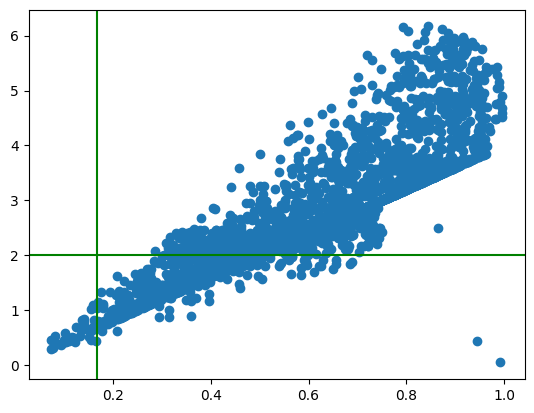

In [29]:
tmp.plot_cnxt()

In [74]:
model=NumpyModel.from_checkpoint('runs/Jul04_14-33-35_TLS-MBP.local/best_model.lt')
model.initialise_weights()

In [77]:
data = pd.read_csv('dataset/original_data/test.csv')[:100]
s1, s2, pro, ref = data.iloc[random.randint(0,len(data))][['sentence1', 'sentence2', 'pronoun', 'referent']]
diag_og = ansatz(sent2dig(s1, s2, pro, ref, mode='none'))
diag_sp = ansatz(sent2dig(s1, s2, pro, ref, mode='spider'))

In [79]:
model.get_diagram_output([diag_og])[0]

array([[0.45872997, 0.1766415 ],
       [0.18094657, 0.18368195]])